## Data understanding

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration4').getOrCreate()
import warnings
warnings.filterwarnings('ignore')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 07:17:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
yield_df = spark.read.csv("data/yield.csv", header=True, inferSchema=True)
temperature_df = spark.read.csv("data/temp.csv", header=True, inferSchema=True)
rainfall_df = spark.read.csv("data/rainfall.csv", header=True, inferSchema=True)
pesticides_df = spark.read.csv("data/pesticides.csv", header=True, inferSchema=True)

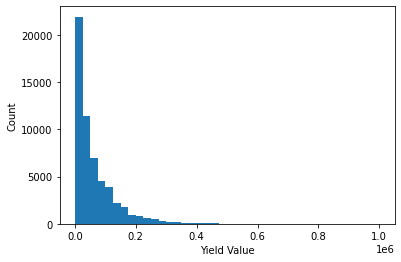

In [3]:
import matplotlib.pyplot as plt
yield_values = yield_df.select("Value").rdd.flatMap(lambda x: x).collect()
plt.hist(yield_values, bins=40)
plt.xlabel('Yield Value')
plt.ylabel('Count')
plt.show()

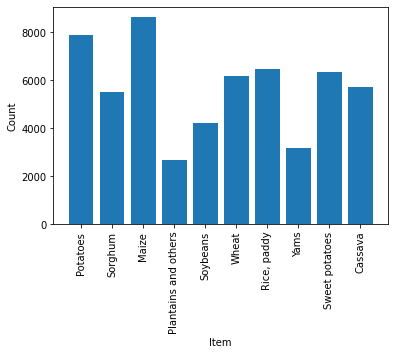

In [4]:
item_values = yield_df.groupBy("Item").count().rdd.flatMap(lambda x: x).collect()
items = [item_values[i] for i in range(0, len(item_values), 2)]
counts = [item_values[i] for i in range(1, len(item_values), 2)]
plt.bar(items, counts)
plt.xlabel('Item')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

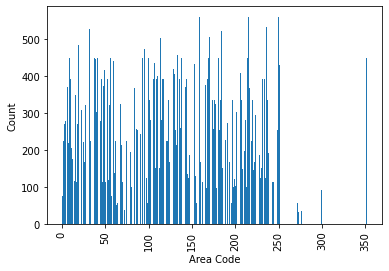

In [5]:
area_code_values = yield_df.groupBy("Area Code").count().rdd.flatMap(lambda x: x).collect()
area_codes = [area_code_values[i] for i in range(0, len(area_code_values), 2)]
counts = [area_code_values[i] for i in range(1, len(area_code_values), 2)]
plt.bar(area_codes, counts)
plt.xlabel('Area Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

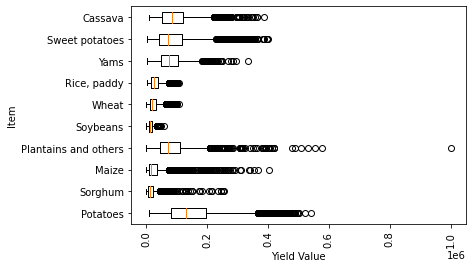

In [6]:
from pyspark.sql import functions as F

# Collect data for box plotting
boxplot_data = yield_df.groupBy("Item").agg(F.collect_list("Value").alias("Values")).collect()
items = [row["Item"] for row in boxplot_data]
values = [row["Values"] for row in boxplot_data]

# Plot
plt.boxplot(values, labels=items, vert=False)
plt.xlabel('Yield Value')
plt.ylabel('Item')
plt.xticks(rotation=90)
plt.show()

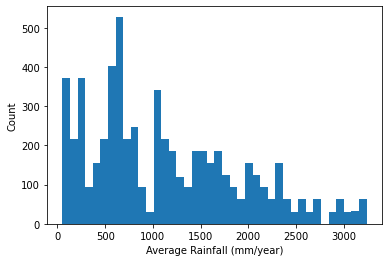

In [8]:
from pyspark.sql.types import FloatType

temp_df = rainfall_df.withColumn("average_rain_fall_mm_per_year", rainfall_df["average_rain_fall_mm_per_year"].cast(FloatType()))
temp_df = temp_df.filter(temp_df["average_rain_fall_mm_per_year"].isNotNull())
rainfall_values = temp_df.select("average_rain_fall_mm_per_year").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.hist(rainfall_values, bins=40)
plt.xlabel('Average Rainfall (mm/year)')
plt.ylabel('Count')
plt.show()


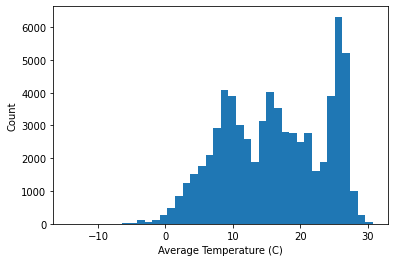

In [9]:
temp_df1 = temperature_df.withColumn("avg_temp", temperature_df["avg_temp"].cast(FloatType()))
temp_df1 = temp_df1.filter(temp_df1["avg_temp"].isNotNull())
temperature_values = temp_df1.select("avg_temp").rdd.flatMap(lambda x: x).collect()

plt.hist(temperature_values, bins=40)
plt.xlabel('Average Temperature (C)')
plt.ylabel('Count')
plt.show()

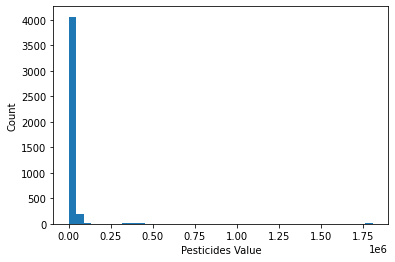

In [10]:
pesticides_values = pesticides_df.select("Value").rdd.flatMap(lambda x: x).collect()

plt.hist(pesticides_values, bins=40)
plt.xlabel('Pesticides Value')
plt.ylabel('Count')
plt.show()

+-------+-----------+------+------------------+-----------+------------+-------+------------------+-------+-----------------+-----------------+-----+-----------------+
|summary|Domain Code|Domain|         Area Code|       Area|Element Code|Element|         Item Code|   Item|        Year Code|             Year| Unit|            Value|
+-------+-----------+------+------------------+-----------+------------+-------+------------------+-------+-----------------+-----------------+-----+-----------------+
|  count|      56717| 56717|             56717|      56717|       56717|  56717|             56717|  56717|            56717|            56717|56717|            56717|
|   mean|       null|  null|125.65042227198195|       null|      5419.0|   null|111.61165082779414|   null|1989.669569970203|1989.669569970203| null|62094.66008427808|
| stddev|       null|  null| 75.12019495452651|       null|         0.0|   null|101.27843534146328|   null|16.13319773965858|16.13319773965858| null|67835.93285

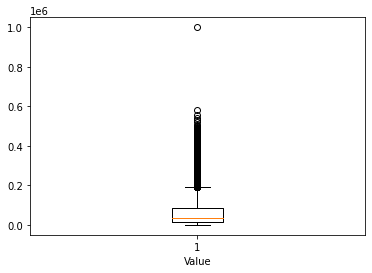

In [11]:
# data quality check
# yeild dataset
# Descriptive statistics
yield_df.describe().show()

# Null value check
yield_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in yield_df.columns]).show()

# Boxplot for Value column
yield_values_for_boxplot = yield_df.select("Value").rdd.flatMap(lambda x: x).collect()
plt.boxplot(yield_values_for_boxplot)
plt.xlabel('Value')
plt.show()

In [12]:
from pyspark.sql.functions import expr

def count_outliers(df, col_name):
    bounds = df.agg(
        F.expr(f'percentile({col_name}, array(0.25))')[0].alias('Q1'),
        F.expr(f'percentile({col_name}, array(0.75))')[0].alias('Q3')
    ).collect()[0]

    IQR = bounds.Q3 - bounds.Q1
    lower_bound = bounds.Q1 - 3.0 * IQR
    upper_bound = bounds.Q3 + 3.0 * IQR

    outliers = df.filter((df[col_name] < lower_bound) | (df[col_name] > upper_bound))
    return outliers.count()


In [13]:
datasets = [yield_df, rainfall_df, pesticides_df, temperature_df]
columns = ["Value", "average_rain_fall_mm_per_year", "Value", "avg_temp"]

for df, col in zip(datasets, columns):
    print(f"Outliers for {col}: ", count_outliers(df, col))
    print("Missing Values for ", col, ":")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Outliers for Value:  777
Missing Values for  Value :
+-----------+------+---------+----+------------+-------+---------+----+---------+----+----+-----+
|Domain Code|Domain|Area Code|Area|Element Code|Element|Item Code|Item|Year Code|Year|Unit|Value|
+-----------+------+---------+----+------------+-------+---------+----+---------+----+----+-----+
|          0|     0|        0|   0|           0|      0|        0|   0|        0|   0|   0|    0|
+-----------+------+---------+----+------------+-------+---------+----+---------+----+----+-----+

Outliers for average_rain_fall_mm_per_year:  0
Missing Values for  average_rain_fall_mm_per_year :
+-----+----+-----------------------------+
| Area|Year|average_rain_fall_mm_per_year|
+-----+----+-----------------------------+
|    0|   0|                          774|
+-----+----+-----------------------------+

Outliers for Value:  428
Missing Values for  Value :
+------+----+-------+----+----+----+-----+
|Domain|Area|Element|Item|Year|Unit|Value|
+-

## Data preparation

### Select data

In [14]:
yield_df = yield_df.select("Area", "Year", "Value", "Item")
pesticides_df = pesticides_df.select("Area", "Year", "Value")

### clean data

In [15]:
rainfall_df = rainfall_df.withColumn("average_rain_fall_mm_per_year", rainfall_df["average_rain_fall_mm_per_year"].cast(FloatType()))
rainfall_df = rainfall_df.filter(rainfall_df["average_rain_fall_mm_per_year"].isNotNull())

temperature_df = temperature_df.withColumn("avg_temp", temperature_df["avg_temp"].cast(FloatType()))
temperature_df = temperature_df.filter(temperature_df["avg_temp"].isNotNull())

In [16]:
temperature_df = temperature_df.dropDuplicates(["year", "country"])


In [17]:
from pyspark.sql.functions import log10

pesticides_df = pesticides_df.withColumn("Value_transformed", log10(F.col("Value") + 0.0001))


In [18]:
pesticides_df

DataFrame[Area: string, Year: int, Value: double, Value_transformed: double]

### Merge data

In [19]:
rainfall_df = rainfall_df.withColumnRenamed(" Area", "Area")
pesticides_df = pesticides_df.withColumnRenamed("Value", "Pesticide_tonnes")
pesticides_df = pesticides_df.withColumnRenamed("Value_transformed", "Log_Pesticide_tonnes")
temperature_df = temperature_df.withColumnRenamed("country", "Area")  
temperature_df = temperature_df.withColumnRenamed("year", "Year")  

merged_df = yield_df.join(pesticides_df, ["Area", "Year"], "inner")
merged_df = merged_df.join(rainfall_df, ["Area", "Year"], "inner")
yield_final_df = merged_df.join(temperature_df, ["Area", "Year"], "inner")


In [20]:
yield_final_df.count()

13130

In [21]:
yield_final_df

DataFrame[Area: string, Year: int, Value: int, Item: string, Pesticide_tonnes: double, Log_Pesticide_tonnes: double, average_rain_fall_mm_per_year: float, avg_temp: float]

### Construct data

In [22]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Indexing the 'Area' column
area_indexer = StringIndexer(inputCol="Area", outputCol="AreaIndex")
area_encoder = OneHotEncoder(inputCol="AreaIndex", outputCol="AreaVec")

# Indexing the 'Item' column
item_indexer = StringIndexer(inputCol="Item", outputCol="ItemIndex")
item_encoder = OneHotEncoder(inputCol="ItemIndex", outputCol="ItemVec")

# Constructing the pipeline
pipeline = Pipeline(stages=[area_indexer, item_indexer, area_encoder, item_encoder])

# Applying the transformations
yield_final_df = pipeline.fit(yield_final_df).transform(yield_final_df)

# drop the original attributes
yield_final_df = yield_final_df.drop("Area", "Item", "AreaIndex", "ItemIndex")


In [23]:
yield_final_df

DataFrame[Year: int, Value: int, Pesticide_tonnes: double, Log_Pesticide_tonnes: double, average_rain_fall_mm_per_year: float, avg_temp: float, AreaVec: vector, ItemVec: vector]

## Data transformation

### reduce data

In [24]:
yield_final_df = yield_final_df.drop("Year")


In [26]:
from pyspark.sql.functions import col

yield_final_df = yield_final_df.withColumn("log_yield_value", log10(col("Value") + 0.0001))


In [27]:
yield_final_df

DataFrame[Value: int, Pesticide_tonnes: double, Log_Pesticide_tonnes: double, average_rain_fall_mm_per_year: float, avg_temp: float, AreaVec: vector, ItemVec: vector, log_yield_value: double]

## Data mining

In [29]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [34]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [43]:
!pip install pyarrow


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 27.8 MB/s eta 0:00:0000:0100:01


In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import (
    LinearRegression, GBTRegressor, RandomForestRegressor, DecisionTreeRegressor
)
from pyspark.ml import Pipeline
from xgboost.spark import SparkXGBRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


In [38]:
models = [
    ("LinearRegression", LinearRegression(featuresCol='features', 
                                          labelCol='log_yield_value',
                                          regParam=0.1,         # Regularization parameter
                                          elasticNetParam=0)),  # L2 regularization
    ("GBTRegressor", GBTRegressor(featuresCol='features', 
                                  labelCol='log_yield_value', 
                                  maxIter=200)),
    ("RandomForestRegressor", RandomForestRegressor(featuresCol='features', labelCol='log_yield_value', numTrees=200)),
    ("DecisionTreeRegressor", DecisionTreeRegressor(featuresCol='features', labelCol='log_yield_value')),
    ("SparkXGBRegressor", SparkXGBRegressor(features_col='features', label_col='log_yield_value', eta=0.5, numRound=200))
]


In [39]:
columns_to_drop = ['Value', 'Pesticide_tonnes', 'log_yield_value']
feature_columns = [col for col in yield_final_df.columns if col not in columns_to_drop]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(yield_final_df)

In [40]:
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

In [50]:
from pyspark.ml.evaluation import RegressionEvaluator

best_model_name = ""
best_r2 = float("-inf")
best_predictions = None
fitted_models = []

for model_name, model in models:
    model_fit = model.fit(train_data)
    fitted_models.append((model_name, model_fit))
    predictions = model_fit.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="log_yield_value", predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(predictions)

    if r2 > best_r2:
        best_r2 = r2
        best_model_name = model_name
        best_predictions = predictions

    print(f"{model_name}: R2 = {r2}")

print(f"Best Model: {best_model_name} with R2: {best_r2}")

23/10/11 09:06:42 WARN Instrumentation: [16ba1516] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 09:06:43 WARN Instrumentation: [16ba1516] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


LinearRegression: R2 = 0.7854677887470305


23/10/11 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1001.2 KiB
23/10/11 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
23/10/11 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1002.4 KiB
23/10/11 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1003.6 KiB
23/10/11 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB
23/10/11 09:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
23/10/11 09:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
23/10/11 09:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
23/10/11 09:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
23/10/11 09:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1011.7 KiB
23/10/11 09:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1014.1 KiB
23/10/11 09:07:36 WAR

23/10/11 09:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1132.1 KiB
23/10/11 09:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1134.3 KiB
23/10/11 09:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1134.8 KiB
23/10/11 09:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1135.4 KiB
23/10/11 09:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1136.6 KiB
23/10/11 09:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1139.0 KiB
23/10/11 09:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1141.7 KiB
23/10/11 09:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1142.2 KiB
23/10/11 09:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1142.8 KiB
23/10/11 09:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1144.0 KiB
23/10/11 09:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1146.4 KiB
23/10/11 09:07:47 WAR

23/10/11 09:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1262.6 KiB
23/10/11 09:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1263.9 KiB
23/10/11 09:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1266.0 KiB
23/10/11 09:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1268.6 KiB
23/10/11 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1269.2 KiB
23/10/11 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1269.8 KiB
23/10/11 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1271.0 KiB
23/10/11 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1273.4 KiB
23/10/11 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1275.8 KiB
23/10/11 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1276.3 KiB
23/10/11 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB
23/10/11 09:07:59 WAR

23/10/11 09:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1395.2 KiB
23/10/11 09:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1395.8 KiB
23/10/11 09:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1397.0 KiB
23/10/11 09:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1399.1 KiB
23/10/11 09:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1401.4 KiB
23/10/11 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1401.9 KiB
23/10/11 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1402.5 KiB
23/10/11 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1403.7 KiB
23/10/11 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1405.9 KiB
23/10/11 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1408.3 KiB
23/10/11 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1408.8 KiB
23/10/11 09:08:10 WAR

23/10/11 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1528.1 KiB
23/10/11 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1528.6 KiB
23/10/11 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1529.3 KiB
23/10/11 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1530.4 KiB
23/10/11 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1532.6 KiB
23/10/11 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1534.8 KiB
23/10/11 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1535.3 KiB
23/10/11 09:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1536.0 KiB
23/10/11 09:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1537.2 KiB
23/10/11 09:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1539.3 KiB
23/10/11 09:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1541.7 KiB
23/10/11 09:08:23 WAR

GBTRegressor: R2 = 0.9307670192220984


23/10/11 09:08:34 WARN DAGScheduler: Broadcasting large task binary with size 1393.8 KiB


RandomForestRegressor: R2 = 0.6454856343023961
DecisionTreeRegressor: R2 = 0.6096331445261178


2023-10-11 09:08:41,290 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eta': 0.5, 'numRound': 200, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[09:08:44] task 0 got new rank 0                                    (0 + 1) / 1]
/home/ubuntu/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:08:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "numRound" } are not used.

  warnings.warn(smsg, UserWarning)
2023-10-11 09:08:45,490 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs


SparkXGBRegressor: R2 = 0.9420494688626951
Best Model: SparkXGBRegressor with R2: 0.9420494688626951


INFO:XGBoost-PySpark:Do the inference on the CPUs


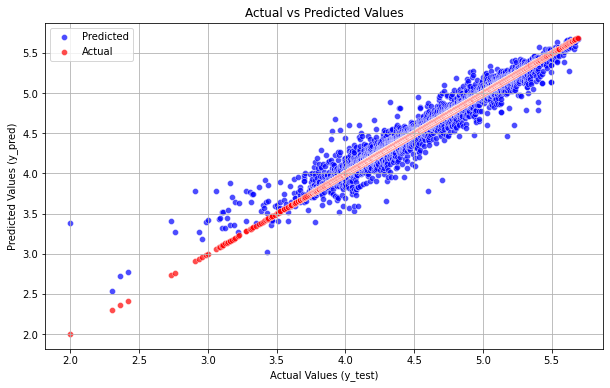

In [51]:
# Visualization
predicted_values = best_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
actual_values = best_predictions.select("log_yield_value").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_values, y=predicted_values, alpha=0.7, color='blue', label='Predicted')
sns.scatterplot(x=actual_values, y=actual_values, alpha=0.7, color='red', label='Actual')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.legend()
plt.show()

In [55]:
# Retrieve the best model object from the 'models' list based on 'best_model_name'
best_model_obj = [model for name, model in fitted_models if name == best_model_name][0]

if best_model_name in ["RandomForestRegressor", "GBTRegressor"]:
    # Extracting feature importances
    importances = best_model_obj.stages[-1].featureImportances.toArray()
    
    # Zipping feature names with their importance scores
    importance_dict = dict(zip(feature_columns, importances))
    
    # Sorting features based on importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Printing top 10 features
    for i, (feature, importance) in enumerate(sorted_importance[:10]):
        print(f"{i+1}. Feature: {feature}, Importance: {importance}")
else:
     
    booster = best_model_obj.get_booster()
    
    feature_scores = booster.get_score(importance_type='weight')
    
    feature_names = [f"f{index}" for index in range(len(feature_columns))]
    importance_dict = {feature_columns[int(f[1:])]: score for f, score in feature_scores.items() if f in feature_names}
    
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    for i, (feature, importance) in enumerate(sorted_importance[:]):
        print(f"{i+1}. Feature: {feature}, Importance: {importance}")

1. Feature: Log_Pesticide_tonnes, Importance: 1238.0
2. Feature: avg_temp, Importance: 1007.0
3. Feature: average_rain_fall_mm_per_year, Importance: 216.0
4. Feature: AreaVec, Importance: 24.0
5. Feature: ItemVec, Importance: 18.0


## Iteration

In [ ]:
columns_to_drop = ['Value', 'Log_Pesticide_tonnes', 'log_yield_value']
feature_columns = [col for col in yield_final_df.columns if col not in columns_to_drop]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(yield_final_df)

train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

best_model_name = ""
best_r2 = float("-inf")
best_predictions = None
fitted_models = []

for model_name, model in models:
    model_fit = model.fit(train_data)
    fitted_models.append((model_name, model_fit))
    predictions = model_fit.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="log_yield_value", predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(predictions)

    if r2 > best_r2:
        best_r2 = r2
        best_model_name = model_name
        best_predictions = predictions

    print(f"{model_name}: R2 = {r2}")

print(f"Best Model: {best_model_name} with R2: {best_r2}")

predicted_values = best_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
actual_values = best_predictions.select("log_yield_value").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_values, y=predicted_values, alpha=0.7, color='blue', label='Predicted')
sns.scatterplot(x=actual_values, y=actual_values, alpha=0.7, color='red', label='Actual')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.legend()
plt.show()

# Retrieve the best model object from the 'models' list based on 'best_model_name'
best_model_obj = [model for name, model in fitted_models if name == best_model_name][0]

if best_model_name in ["RandomForestRegressor", "GBTRegressor"]:
    # Extracting feature importances
    importances = best_model_obj.stages[-1].featureImportances.toArray()
    
    # Zipping feature names with their importance scores
    importance_dict = dict(zip(feature_columns, importances))
    
    # Sorting features based on importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Printing top 10 features
    for i, (feature, importance) in enumerate(sorted_importance[:10]):
        print(f"{i+1}. Feature: {feature}, Importance: {importance}")
else:
     
    booster = best_model_obj.get_booster()
    
    feature_scores = booster.get_score(importance_type='weight')
    
    feature_names = [f"f{index}" for index in range(len(feature_columns))]
    importance_dict = {feature_columns[int(f[1:])]: score for f, score in feature_scores.items() if f in feature_names}
    
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    for i, (feature, importance) in enumerate(sorted_importance[:]):
        print(f"{i+1}. Feature: {feature}, Importance: {importance}")